In [49]:
import numpy as np
from numpy import dot
import matplotlib.pyplot as plt
import math

import sympy
from IPython.display import display

def randn():
    return np.random.randn()
def sqrt(x):
    return np.sqrt(x)
plt.rcParams['axes.facecolor']='xkcd:sky blue'

### Base for ball trajectory ..  Will add non-linearilty later

In [3]:
#### Used for ball trajectory preparation,..

def rk4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply to 
      compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

def fx(x,t):
    return fx.vel
    
def fy(y,t):
    return fy.vel - 9.8*t


class BallTrajectory2D(object):
    def __init__(self, x0, y0, velocity, theta_deg=0., g=9.8, noise=[0.0, 0.0]):
        self.x = x0
        self.y = y0
        self.t = 0        
        theta = math.radians(theta_deg)
        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity        
        self.g = g
        self.noise = noise
        
        
    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt 


        return np.array([[self.x + randn()*self.noise[0], self.y + randn()*self.noise[1]]]).T

### Linear Kalman filter class

In [9]:
#################################################
#######  Simple Linear Kalman filter...
################################################

class KALMAN_FILTER:
    def __init__(self,A,H, P = None,Q= None,R= None,B= None,U= None,X= None   ):
        ### initial values 
        
        self.n = A.shape[1]
        
        self.A = A
        self.H = H
        
        self.P =  P if(P is not None) else np.eye(self.n)   
        self.Q =  Q if(Q is not None) else np.eye(self.n)  
        self.R =  R if(R is not None) else np.eye(self.n)  
        self.B = B if(B is not None) else 0
        self.U = U if(U is not None) else 0
        self.X = X if(X is not None) else np.zeros((self.n, 1)) 
        
    
            
    
    def prediction(self):
        ##################
        X = self.X
        P = self.P
        A= self.A
        Q= self.Q 
        B= self.B 
        U= self.U

        ################3#
        self.X = np.dot(A, X) + np.dot(B, U)
        self.P = np.dot(A, np.dot(P, A.T)) + Q
        
        return self.X
        
    
    def updation(self,Y):
        
        #################
        X = self.X
        
        P = self.P
        H = self.H
        R = self.R       
        ################
        
        if(Y.shape != np.dot(H,X).shape):
            print("Error in updation, dim error")
            return
        
        V = Y - np.dot(H,X) ### innovation process
        S = np.dot(H, np.dot(P,H.T)) + R  ### measure predictive cov
        K = np.dot(P,np.dot(H.T,np.linalg.inv(S) ))
        self.X = X + np.dot(K,V)
        self.P = P - np.dot(K,np.dot(S,K.T))
        
         

### Extended kalman filter  ... adds in func to compute jacobian

In [10]:
#################################################
#######  Extended Kalman filter...  Trial 1
################################################

class Extended_KALMAN_FILTER:
    def __init__(self,A,H,dt, P = None,Q= None,R= None,X= None   ):
        ### initial values 
        
        self.n = A.shape[1]
        
        self.A = A
        self.H = H
        
        self.P =  P if(P is not None) else np.eye(self.n)   
        self.Q =  Q if(Q is not None) else np.eye(self.n)  
        self.R =  R if(R is not None) else np.eye(self.n)  

        self.X = X if(X is not None) else np.zeros((self.n, 1)) 
        self.dt = dt
        
        #########################################################
        x,v_x,y,v_y,step = sympy.symbols(' x , v_x , y , v_y ,dt ')
        v = sympy.sqrt(v_x**2 + v_y**2)
        F = ( (0.0058/(1+sympy.exp( (v-35)/5 ) ) ))

        a1 = x+v_x*step
        a2 = v_x - F*(v_x)*step
        a3 = y + v_y*step
        a4 = v_y - 9.8*step - F*(v_y)*step

        H = sympy.Matrix([ a1, a2, a3, a4])
        state = sympy.Matrix([x,v_x,y,v_y])

        self.J = H.jacobian(state)
        display(self.J)
        
        self.subs = {step:dt, v_x:0,v_y:0}
        self.v_x, self.v_y, self.step = v_x,v_y,dt
        
        #########################################################        
    
    def prediction(self):
        
        #####################################################     Calculate the A
        X = self.X
        P = self.P
            
        self.subs[self.v_x] = X.item(1)
        self.subs[self.v_y] = X.item(3)
        A = np.array( self.J.evalf(subs = self.subs) ).astype(float)
        ########################################################

        
        ### A missing should be given ... the jacobian matrix..
        ### Compiting jacobian using X: A
        Q= self.Q 
        dt = self.dt
        ################3#
        
        x_vel,y_vel = X.item(1),X.item(3)
        vel = (x_vel**2 + y_vel**2)**0.5
        f = (0.0058/1+np.exp( (vel-35)/5 ))
        
        dX = dt* np.array([X[1],-1*f*X[1],X[3],-1*f*X[3]-9.8 ])
        dX = dX.reshape(X.shape)

        self.X = X + dX
        self.P = np.dot(A, np.dot(P, A.T)) + Q

        return self.X
        
    
    def updation(self,Y):
        
        #################
        X = self.X
        
        P = self.P
        H = self.H
        R = self.R       
        ################
        
        if(Y.shape != np.dot(H,X).shape):
            print("Error in updation, dim error")
            return
        
        V = Y - np.dot(H,X) ### innovation process
        S = np.dot(H, np.dot(P,H.T)) + R  ### measure predictive cov
        K = np.dot(P,np.dot(H.T,np.linalg.inv(S) ))
        self.X = X + np.dot(K,V)
        self.P = P - np.dot(K,np.dot(S,K.T))
        
         

### Adding non-linearity and simulating measurements.

In [11]:

class BaseballPath:
    def __init__(self, x0, y0, launch_angle_deg, velocity_ms, 
                 noise=(1.0, 1.0)): 
        """ Create 2D baseball path object  
           (x = distance from start point in ground plane, 
            y=height above ground)
        
        x0,y0            initial position
        launch_angle_deg angle ball is travelling respective to 
                         ground plane
        velocity_ms      speeed of ball in meters/second
        noise            amount of noise to add to each position
                         in (x, y)
        """
        
        omega = np.radians(launch_angle_deg)
        self.v_x = velocity_ms * np.cos(omega)
        self.v_y = velocity_ms * np.sin(omega)

        self.x = x0
        self.y = y0
        self.noise = noise


    def drag_force(self, velocity):
        """ Returns the force on a baseball due to air drag at
        the specified velocity. Units are SI
        """
        B_m = 0.0039 + 0.0058 / (1. + np.exp((velocity-35.)/5.))
        return B_m * velocity


    def update(self, dt, vel_wind=0.):
        """ compute the ball position based on the specified time 
        step and wind velocity. Returns (x, y) position tuple.
        """

        # Euler equations for x and y
        self.x += self.v_x*dt
        self.y += self.v_y*dt

        # force due to air drag
        v_x_wind = self.v_x - vel_wind
        v = sqrt(v_x_wind**2 + self.v_y**2)
        F = self.drag_force(v)

        # Euler's equations for velocity
        self.v_x = self.v_x - F*v_x_wind*dt
        self.v_y = self.v_y - 9.81*dt - F*self.v_y*dt
        return np.array([[self.x + randn()*self.noise[0], self.y + randn()*self.noise[1]]]).T

### Extended Kalman filtering... and comparing with linear KF

Matrix([
[1,                                                                                                                                                                          dt, 0,                                                                                                                                                                           0],
[0, 0.00116*dt*v_x**2*exp(sqrt(v_x**2 + v_y**2)/5 - 7)/(sqrt(v_x**2 + v_y**2)*(exp(sqrt(v_x**2 + v_y**2)/5 - 7) + 1)**2) - 0.0058*dt/(exp(sqrt(v_x**2 + v_y**2)/5 - 7) + 1) + 1, 0,                                                       0.00116*dt*v_x*v_y*exp(sqrt(v_x**2 + v_y**2)/5 - 7)/(sqrt(v_x**2 + v_y**2)*(exp(sqrt(v_x**2 + v_y**2)/5 - 7) + 1)**2)],
[0,                                                                                                                                                                           0, 1,                                                                                                        

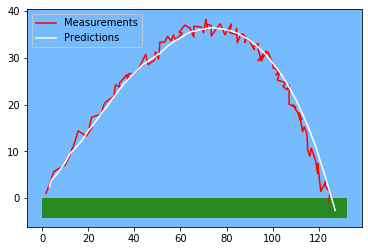

In [51]:

    
def calculate_state_init(v0,x0,y0,theta):
    theta_in_rad = theta * (2*np.pi/360)
    vx = v0* np.math.cos(theta_in_rad)
    vy = v0* np.math.sin(theta_in_rad)
    return np.array([[x0,vx,y0,vy]]).T




#########################################################
#####    Linear Kalman filter
#########################################################

def kf_ball_trajectory(dt,r,theta,v0,x0,y0,q):
    
    #### Initial settings...
    
    A = np.array([[1,dt,0,0],[0,1,0,0],[0,0,1,dt],[0,0,0,1]])
    ### init position using velocity and throwing position...
    X_init = calculate_state_init(v0,x0,y0,theta)
    
    ### Control input
    B = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])  
    U = np.array([[0,0,0,-9.8 * dt]]).T  ### here g = 9.8 is the control input
    
    ### Measurement 
    H = np.array([[1,0,0,0],[0,0,1,0]])  ### Measuring transformation
    R = np.eye(2)*r    ### Cov of measurement noise
    
    ### Process noise can be seen as ov of weights of the filter
    ### Prediction noise cov
    Q = q*np.eye(4) 
    

    
    if(np.dot(A,X_init).shape != np.dot(B,U).shape):
        print("Errrrrroooooorrrrr, Plss checke the dimm")

    
    ### Initialisng kalman filter
    kf = KALMAN_FILTER(A = A,H = H, P = None,Q = Q, R = R,B = B,U = U,X = X_init )
    
    return kf


#########################################################
#####    Extended Kalman filter..
#########################################################
def ekf_ball_trajectory(dt,r,theta,v0,x0,y0,q):
    
    #### Initial settings...
    
    A = np.array([[1,dt,0,0],[0,1,0,0],[0,0,1,dt],[0,0,0,1]])
    ### init position using velocity and throwing position...
    X_init = calculate_state_init(v0,x0,y0,theta)
    
    
    ### Measurement 
    H = np.array([[1,0,0,0],[0,0,1,0]])  ### Measuring transformation
    R = np.eye(2)*r    ### Cov of measurement noise
    
    ### Process noise can be seen as ov of weights of the filter
    ### Prediction noise cov
    Q = q*np.eye(4) 
    

    
    ### Initialisng kalman filter
    ekf = Extended_KALMAN_FILTER(A = A,H = H, dt = dt ,P = None,Q = Q, R = R,X = X_init )
    
    return ekf


x0 , y0 , v0 , theta = 0,0,50,50
state_noise_ball = [1,1]
dt = .1
q1,q2 = 1,0
r1,r2 = .3,.3


x0 , y0 , v0 , theta = 0,0,50,40
state_noise_ball = [1,1]
dt = .05
r,q = .3,0
## Init filter and trajectory meas
ekf = ekf_ball_trajectory(dt = dt, r =  r, theta = theta, v0 = v0,x0 =  x0,y0 = y0,q = q)
#ball_pos = BallTrajectory2D(x0=x0, y0=y0, theta_deg=theta, velocity=v0, noise=state_noise_ball)
ball_pos = BaseballPath(x0=x0, y0=y0, launch_angle_deg=theta, velocity_ms=v0, noise = state_noise_ball)


##### looping until ball reaches grnd . i.e; y < 0
y_meas = 0
step = 0
meas_list = []
preds_list = []

while ( y_meas >= 0):
    meas = ball_pos.update(dt)
    y_meas = meas[1]

    meas_list.append(meas)
    ekf.updation(meas)
    #### Computing the jacobian...
    
    preds = np.dot(ekf.H,ekf.prediction())
    preds_list.append(preds)

meas_list = np.array(meas_list)
preds_list = np.array(preds_list)
plt.plot(meas_list[:,0],meas_list[:,1],label = "Measurements",color = 'r')
plt.plot(preds_list[:,0],preds_list[:,1], label = "Predictions",color = 'w')

x = np.arange(0,np.amax(preds_list) + 5)
plt.fill_between(x,-4, 0.1,color = '#288B22')
plt.legend()



Matrix([
[1,                                                                                                                                                                          dt, 0,                                                                                                                                                                           0],
[0, 0.00116*dt*v_x**2*exp(sqrt(v_x**2 + v_y**2)/5 - 7)/(sqrt(v_x**2 + v_y**2)*(exp(sqrt(v_x**2 + v_y**2)/5 - 7) + 1)**2) - 0.0058*dt/(exp(sqrt(v_x**2 + v_y**2)/5 - 7) + 1) + 1, 0,                                                       0.00116*dt*v_x*v_y*exp(sqrt(v_x**2 + v_y**2)/5 - 7)/(sqrt(v_x**2 + v_y**2)*(exp(sqrt(v_x**2 + v_y**2)/5 - 7) + 1)**2)],
[0,                                                                                                                                                                           0, 1,                                                                                                        

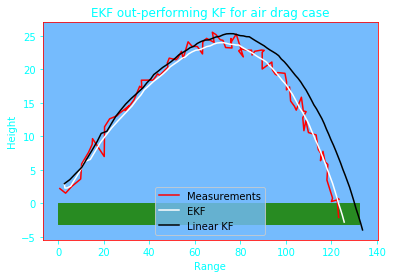

In [73]:


x0 , y0 , v0 , theta = 0,0,50,30
state_noise_ball = [1,1]
dt = .05
r,q = .3,0

## Init filter and trajectory meas
ekf = ekf_ball_trajectory(dt = dt, r =  r, theta = theta, v0 = v0,x0 =  x0,y0 = y0,q = q)
kf = kf_ball_trajectory(dt = dt, r =  r, theta = theta, v0 = v0,x0 =  x0,y0 = y0,q = q)
#ball_pos = BallTrajectory2D(x0=x0, y0=y0, theta_deg=theta, velocity=v0, noise=state_noise_ball)
ball_pos = BaseballPath(x0=x0, y0=y0, launch_angle_deg=theta, velocity_ms=v0, noise = state_noise_ball)


##### looping until ball reaches grnd . i.e; y < 0
y_meas = 0
step = 0
meas_list = []
preds_list_ekf = []
preds_list_kf = []

while ( y_meas >= 0):
    meas = ball_pos.update(dt)
    y_meas = meas[1]

    meas_list.append(meas)
    ekf.updation(meas)    #### Extended
    kf.updation(meas)     #### linear
    
    preds_ekf = np.dot(ekf.H,ekf.prediction())
    preds_kf = np.dot(kf.H,kf.prediction())
    
    preds_list_ekf.append(preds_ekf)
    preds_list_kf.append(preds_kf)
    

meas_list = np.array(meas_list)
preds_list_ekf = np.array(preds_list_ekf)
preds_list_kf = np.array(preds_list_kf)
plt.plot(meas_list[:,0],meas_list[:,1],label = "Measurements",color = 'r')
plt.plot(preds_list_ekf[:,0],preds_list_ekf[:,1], label = "EKF",color = 'w')
plt.plot(preds_list_kf[:,0],preds_list_kf[:,1], label = "Linear KF",color = 'black')


plt.rc_context({'axes.edgecolor':'red', 'xtick.color':'cyan', 'ytick.color':'cyan'})

plt.title("EKF out-performing KF for air drag case",color = 'cyan')
x = np.arange(0,np.amax(preds_list) + 5)
plt.fill_between(x,-3, 0.1,color = '#288B22')

plt.xlabel("Range",color = 'cyan')
plt.ylabel("Height",color = 'cyan')

plt.legend()